**Brigham Young University**

```
Sophie Carter
Morgan Nielsen 
Michelle Wang
Sarah Winters
```

# **Introduction**

## **Background**

&emsp; &nbsp; LinkedIn, established in 2002, has evolved into a pivotal platform for professionals to connect, network, and explore employment opportunities. With over 800 million members worldwide, LinkedIn remains a powerhouse in the realm of professional social networking. The platform serves as a dynamic repository of job postings, providing a comprehensive snapshot of the global employment landscape. Job overviews on LinkedIn encapsulate a wealth of information, offering detailed insights into the skill sets, qualifications, and responsibilities associated with various positions. As the professional world continues to embrace digital transformation, the sheer volume of data generated by LinkedIn job postings becomes an invaluable resource for researchers and organizations seeking to gain a nuanced understanding of labor market trends.


## **Motivation**

&emsp; &nbsp; As college seniors who are navigating challenges of job applications for entry-level positions, our motivation for undertaking this project is deeply rooted in our personal experiences and the collective anxiety associated with the transition from academia to the professional sphere. In fact, one of our group members was inspired after seeing a post on LinkedIn that depicted a made-up graph representing the contrast in Entry level positions open, and the number of new graduates looking for them. Recognizing the significance of securing gainful employment post-graduation, we, as a group, sought to explore a topic that not only resonated with our immediate concerns but also allowed us to leverage our skills in data analysis and machine learning. Initially, our research led us to consider mapping unemployment trends among newly graduated students. However, we encountered obstacles in obtaining clear and comprehensive data, coupled with a lack of robust techniques to effectively analyze this aspect of the job market.

&emsp; &nbsp; Upon furthering our research, we found a dataset containing LinkedIn job postings from the year 2023. This discovery prompted a shift in our focus, steering us towards the prospect of predicting salary ranges for entry-level positions—a pivotal aspect of the employment equation that directly impacts our cohort. The availability of real-time data from a platform as influential as LinkedIn presented a unique opportunity to apply machine learning algorithms to decipher patterns and trends in salary expectations. Our motivation stems from a desire to contribute not only to our academic pursuits but also to address a practical and immediate concern shared by many in our position—deciphering the salary landscape of entry-level job opportunities in 2023.

## **Overview**

&emsp; &nbsp; We had three main questions that we wanted to answer throughout this paper. First, we wanted to determine if our dataset could help us create a model to predict the formatted experience level based on the minimum and maximum salaries. We also wanted to observe the other way around—how our model can predict salary ranges based on information like location, experience level, and description. Finally, we wanted to determine common words in job descriptions and necessary skills, to be able to determine entry-level jobs; our greatest interest here is specifically in entry-level jobs, since in our personal job hunting experiences, we have run across job descriptions that contradict the formatted experience level.

# **The Data**

## **Data Description**

&emsp; &nbsp; Originally, we were going to use two datasets—one about underemployment and one that included LinkedIn job postings from 2023. However, we realized after our proposal and looking more closely at the data that the underemployment dataset wouldn’t be very relevant with the information we could extract from the second dataset. The LinkedIn dataset is a record of over 33,000 job postings spread out between two separate days in 2023 that are months apart. The dataset includes 27 features total, though we mostly used minimum salary, maximum salary, formatted experience level, job description, location, and necessary skills listed. We exported the data as a CSV file from Kaggle and seamlessly imported it into our analysis notebook using the pandas function ```read_csv()```. This decision not only facilitated our data manipulation but also ensured that our analytical process remained efficient and focused on the key parameters critical for predicting entry-level job salaries.

In [2]:
job_postings_data = pd.read_csv('job_postings.csv')

## **Data Preparation**

&emsp; &nbsp;   Unfortunately, many features in the dataset have hundreds or thousands of NaN values. To observe which columns had the most missing data, we used the pandas feature ```.isna().sum()``` to observe the list of features and the number of missing values listed for each. The most important data to us were those corresponding with description, salary, experience level, location, and skills. Because of this, we originally looked at the rows that had this data missing, and dropped the NaN values for description, and then the data for maximum salary, which were the same rows that were missing minimum salary as well. Finally, we decided to drop data that didn’t have a formatted experience level. 

In [3]:
# look at the missing data
missing_data = job_postings_data.isna().sum()

&emsp; &nbsp; After dropping these NaN values, we felt there was still sufficient data for our analysis, which was part of the reason we felt this dataset was adequate for the predictions and observations we were going to make. Usually we would want to replace the missing data with something that still had value to our model, so we wouldn't lose any information that could assist with our predictions. However, we could not find appropriate replacements for our missing data in the features that were most important to our question, so we were forced to drop these rows. We later created one-hot encodings for each type of experience level, so we could go through each one and observe the accuracy of our model’s predictions. Though the way we cleaned this data is quite specific to this dataset, we believe that if this dataset were to be updated, or if we used similar data concerning job postings, it would be easy to apply our methods to the new data. 

&emsp; &nbsp; In other sections, when we do not analyze the salary column we do not drop the same jobs. We do this so that we are not throwing out useful data. For example when predicting based on job description and experience levels, we dropped the jobs with empty experience levels because there was not a way to fill in what the experience levels should have been.

## **Feature Engineering**

&emsp; &nbsp; Because we are using minimum and maximum salary in all three of our questions, we wanted to ensure that the format of these columns were consistent for our data points. The pay period column for our DataFrame included three values: hourly, monthly, and yearly. Because our motivation behind this project came from our personal job search as seniors, we decided to narrow it down to full-time positions, so we could convert the hourly and monthly earnings to yearly, by assuming full-time jobs were 40 hours a week. Thus, we multiplied hourly salaries by 40, and then 52, to represent the new annual salary, and the monthly salaries by 12. Though we know these are imperfect estimations, not taking into account PTO or sick days, we felt that it would bring better results than focusing solely on yearly pay periods. 

# **Analysis**

&emsp; &nbsp;Our analysis focuses on classifying the six different experience types: Entry level, Associate, Intern, Executive, Mid-senior level, and Director. Each level of experience has different expected yearly salaries and distributions, so we wanted to observe these differences. It’s expected that as the max salary goes up the more likely the required experience is higher. This prediction is sound while looking at the histograms from some of the data. The director jobs have an expected salary value a lot higher than the entry level jobs. Additionally, the histogram highlights a high frequency in the Mid-Senior Level category, providing support for our experience as students navigating the job market and grappling with the scarcity of entry-level positions. This insight reinforced the challenges we face in securing suitable opportunities at the onset of our professional journeys and inspired us to continue with our predictions and analysis. As there is a lot of missing data, we started our predictions based on just entry level jobs because of our interest, but found that other experience levels are more predictable with our methods.

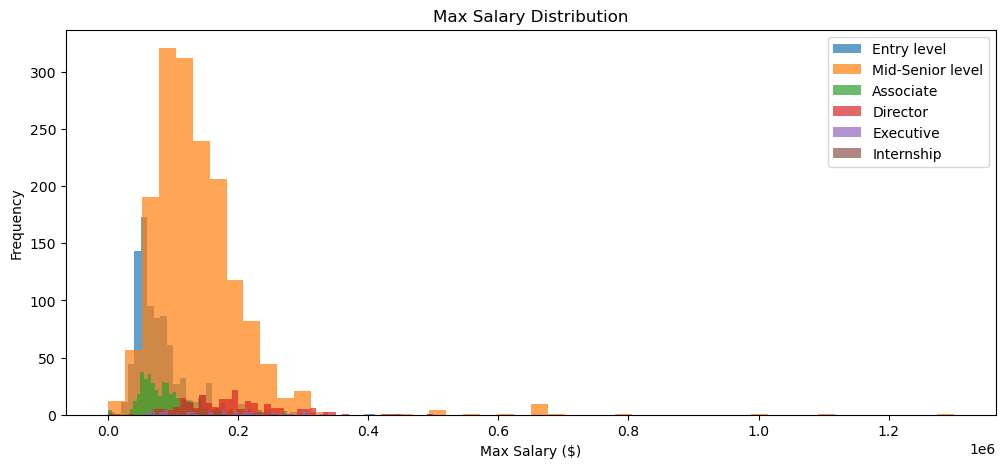

In [5]:
plt.show()

## **Random Forest and Grid Search**

&emsp; &nbsp; To answer our first question, we decided to use random forests to classify our data into the different experience types, using the minimum and maximum salaries. This process included splitting the data into training and testing sets, where 80% of our data was used to train, and the remaining 20% was used to test. In order to see which experience levels our models could predict the best, we created a classification report and observed the precision, recall, and f1-scores. Because the values for these metrics were significantly higher for Entry level and Mid-Senior level positions, we decided to run a grid search on these two specifically.

In [8]:
print(f"RandomForestClassifier Classification: \n {classification_report(y_test, predictions)}")

RandomForestClassifier Classification: 
                   precision    recall  f1-score   support

       Associate       0.29      0.22      0.25        89
        Director       0.41      0.20      0.27        55
     Entry level       0.69      0.62      0.65       180
       Executive       0.00      0.00      0.00         4
      Internship       0.00      0.00      0.00         3
Mid-Senior level       0.65      0.79      0.72       316

        accuracy                           0.61       647
       macro avg       0.34      0.31      0.32       647
    weighted avg       0.58      0.61      0.59       647



&emsp; &nbsp; In order to perform a grid search, we performed a one-hot encoding on the formatted experience type column, and looked at the new columns for Entry level and Mid-Senior level positions. In order to create the most optimal model, we constructed a grid of parameters, and searched through the most ideal parameters for both of our experience levels. These results gave us a best score of 59.3%  in predicting Entry level jobs, and 72.5% while predicting Mid-Senior level. Though these accuracies are far from perfect, it was still interesting to see that our model had some success in predicting experience levels based on the minimum and maximum salaries in the training data. It was also interesting to see that the best parameters from the grid search were almost the same for both Entry and Mid-Senior jobs, with the exception of the criterion, which was gini for Entry, and entropy for Mid-Senior. 

In [11]:
experience_level_predictions('formatted_experience_level_Entry level')

Best Parameters: {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 200}

Best Score: 0.5912866848800131



In [12]:
experience_level_predictions('formatted_experience_level_Mid-Senior level')

Best Parameters: {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 200}

Best Score: 0.7259812331330255



&emsp; &nbsp; We also obtained confusion matrices for both experience levels.  A confusion matrix is used to evaluate the performance of a classification algorithm. Each cell in the matrix represents the count of instances based on the actual and predicted class labels. For the Entry Level Confusion Matrix, there are 435 true negatives, 32 false positives, 81 false negatives, and 99 true positives. For the Mid-Senior Level Confusion Matrix, there are 207 true negatives, 124 false positives, 64 false negatives, and 252 true positives. 

&emsp; &nbsp; We see that the Entry Level model performs overwhelmingly better across all metrics except for the recall metric. Recall for Entry Level is lower, meaning that a smaller proportion of actual Entry Level instances are correctly identified by the model compared to the Mid-Senior Level model. Thus, while the Entry Level model performs better overall, the lower recall for Entry Level suggests that it may be missing a significant portion of actual Entry Level instances. These two models showed us that though our dataset may not be ideal for our question, this helped us measure the effectiveness of using minimum and maximum salaries to predict Entry level and Mid-Senior level jobs.

## **Logistic Regression**

&emsp; &nbsp; Like random forests, logistic regression can also be used to create classification models. Because we wanted to find an optimal model for predicting experience level based on minimum and maximum salary, we decided to use sklearn’s LogisticRegression class to perform a similar procedure as our random forest classifier. Initially, we used the multiclass indicator included in our model to see how well it could categorize all experience levels based on minimum and maximum salary values. After splitting the data similarly to our previous model, adding a constant feature to our X values, and fitting the model to our training data, we used the test data to predict experience level labels based on salary. Though the accuracy score was 48.8%, the scatter plots reveal that the model classified  practically all of the data as a Mid-Senior level job.

In [14]:
# plot the original data
print(full_time_data['formatted_experience_level'].value_counts())

Mid-Senior level    1642
Entry level          872
Associate            442
Director             216
Executive             46
Internship            17
Name: formatted_experience_level, dtype: int64


Model accuracy:  0.4884080370942813


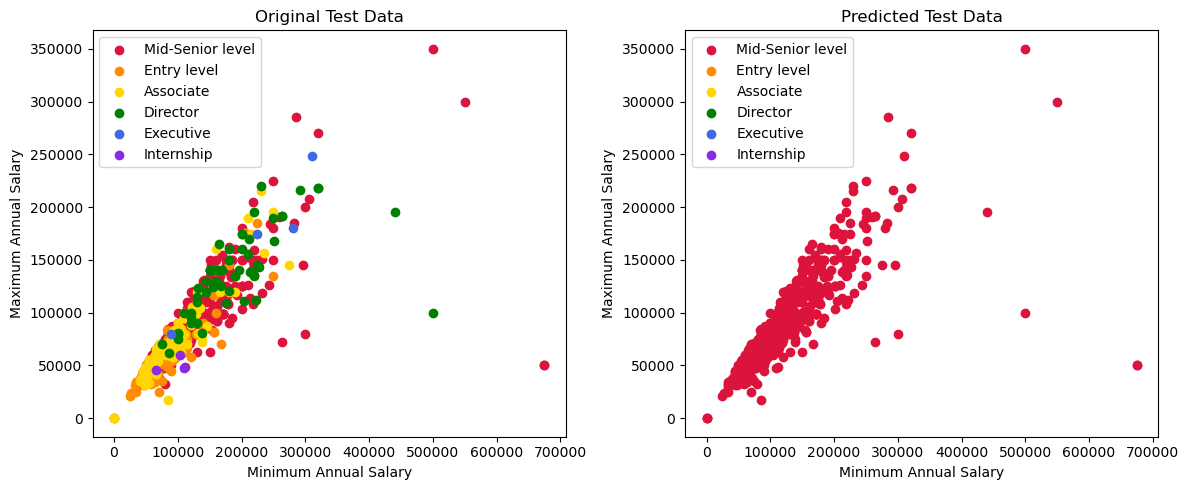

In [15]:
print("Model accuracy: ", accuracy_score(y_test.values, prediction_labels))

&emsp; &nbsp; Because our random forest classifier gave the best scores for Mid-Senior and Entry level jobs, we decided to also train a regression model on filtered data that focused solely on these two experience levels. However, we received similar results: our model did have a higher accuracy of 63.2%, but the scatterplot shows an overwhelming amount of data was classified as Mid-Senior level. 

In [17]:
# now we just want to see mid-senior level and entry level
print(dataframe_with_mask['formatted_experience_level'].value_counts())

Mid-Senior level    1642
Entry level          872
Name: formatted_experience_level, dtype: int64


Model accuracy:  0.6322067594433399


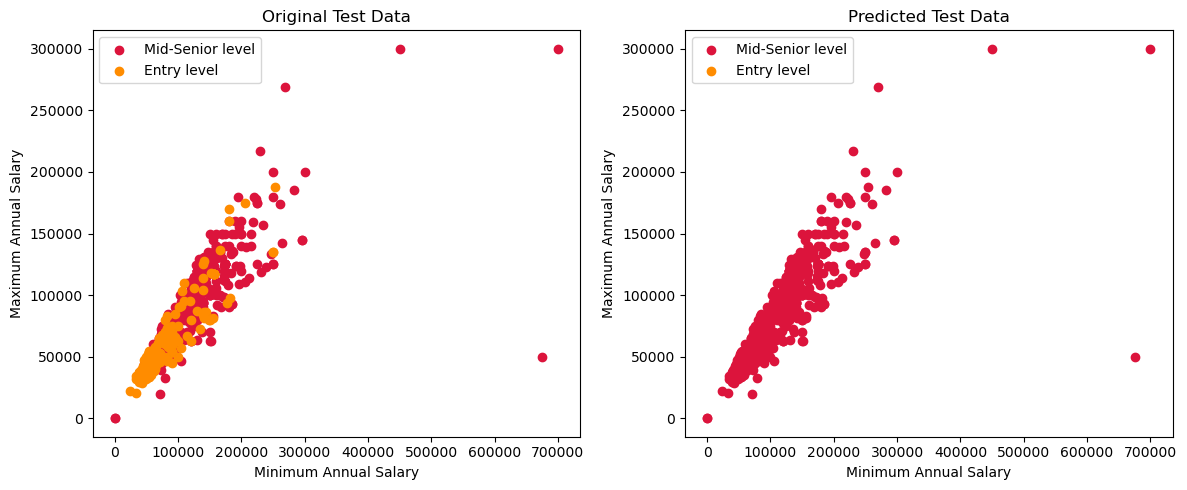

In [18]:
print("Model accuracy: ", accuracy_score(y_test.values, prediction_labels))

&emsp; &nbsp; Finally, to test one more model, we performed a binary classification on whether or not a job was Mid-Senior level, or not. Unfortunately, as our scatter plots show, this gave us the exact same result as our first regression model, with an accuracy of 48.8%. 

Model accuracy:  0.4884080370942813


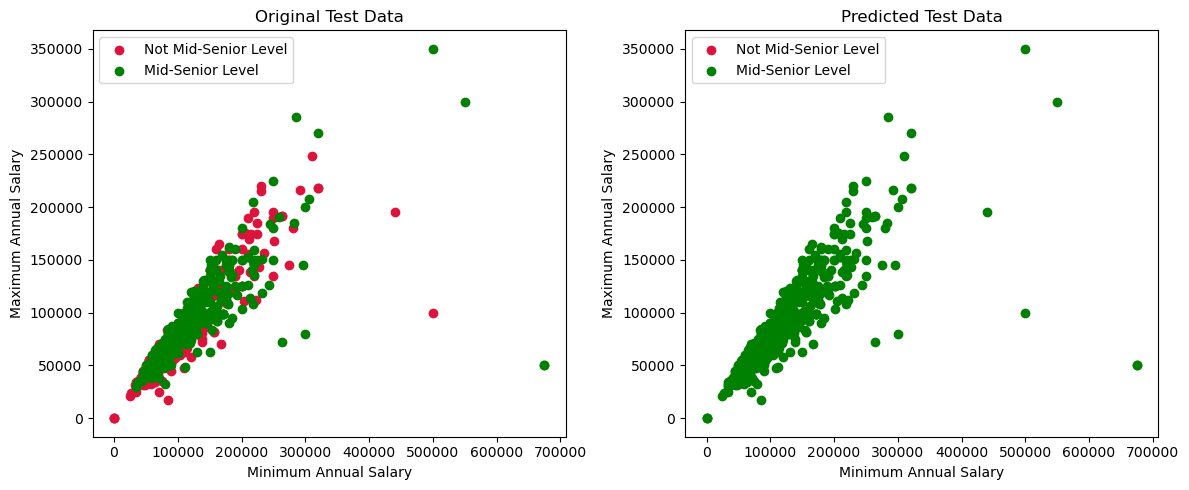

In [19]:
print("Model accuracy: ", accuracy_score(y_test.values, prediction_labels))

&emsp; &nbsp; Though these are rather disappointing results, the spread of data shown on the scatter plots help clarify why our results are true. Not only is the majority of our original data marked as a Mid-Senior level job, but the different levels of experience do have significant overlap with minimum and maximum salaries. Though we expected that these higher-level jobs would pay more, there are many Entry level jobs that have similar salaries to Mid-Senior and other levels of experience. Though we didn’t test this specifically, if we were to dig further into this research, we could analyze these results depending on the field the job is in, to see if it would bring similar or different answers. 

## **Predicting Min/Max Salary Using Experience Level and Location**
### **More Feature Engineering**

&emsp; &nbsp; For the purposes of predicting maximum salary and minimum salary using experience level and location, we continue to clean the data by keeping only the rows with non-null values of max and min salary. We isolate our desired independent variables:  ```location``` and ```formatted_experience_level```. We then define a function that returns the state given an input location in the format of (city, state), else it returns the city. Since the locations are not identically formatted, there are a few entries that return the city name after passing through the function. We independently map each of these cities to their respective states. We also define a function that, given an input state, returns the respective CONUS region according to the U.S. Department of Labor's Wage and Hour Division's regional divisions: West, Southwest, Midwest, Northeast, and Southeast. We use these functions on the ```location``` column in our dataframe to ultimately create a new ```region``` column. Our dataframe now has four columns (See Appendix cell 21-26).

&emsp; &nbsp; We extract our dependent variables: minimum and maximum salary columns, and then one-hot encode our independent variable columns:```region``` and ```formatted_experience_level```, and we set ```drop_first=True``` to prevent multicollinearity. Then, we find all the possible combinations of our independent variables and store them in a list called ```all_combos```.

### **Predicting Min Salary Using Experience Level and Location**

&emsp; &nbsp; We build our model using OLS from ```statsmodule``` and determine the best $R^{2}$ score and the best combination of independent variables. Typically, the closer the $R^{2}$ score is to 1, the better, although this is certainly an oversimplification and overgeneralization. $R^{2}$ is the “percent of variance explained'' by the model. That is, $R^{2}$ is the fraction by which the variance of the errors is less than the variance of the dependent variable. Given our $R^{2}$ score of 0.2532813401285329, our model explains approximately 25.3% of the variance, or approximately 13% of the standard deviation, using the formula of one minus the square root of one-minus-R-squared.

&emsp; &nbsp; The AIC (Akaike Information Criterion) seeks to estimate the relative quality of a statistical model by considering both its goodness of fit and the number of parameters used. It penalizes complex models more severely than simpler ones. Similar to AIC, the BIC (Bayesian Information Criterion) balances model fit and complexity but uses a different penalty term that is more stringent for additional parameters. It tends to penalize complex models more heavily than AIC, particularly for smaller sample sizes.  For both AIC and BIC, lower values are better. Models with lower AIC or BIC are considered to be more parsimonious, effectively capturing the underlying patterns in the data with fewer parameters.

&emsp; &nbsp; The AIC and BIC scores above are extremely high and yet they are the best (lowest) amongst all the different possible combinations of models run. We see that combinations that yield the best $R^{2}$ score, the best AIC score, and the best BIC score are all different.

&emsp; &nbsp; Now we perform Ridge regression, a type of linear regression that introduces a regularization term to prevent overfitting, using the RidgeCV function from the scitkit-learn library. We fit our model, as before, using the independent variable data (experience levels and regions) and the dependent variable (minimum salary). The Ridge score represents the proportion of the variance in the dependent variable that can be explained by the independent variables. In this case, the score of 0.25325813015041865 indicates that the model explains about 25.3% of the variance in the minimum salary values, our dependent variable. Note that this Ridge score is extremely similar to the best $R^{2}$ score obtained. Notably, the determined best $R^{2}$ model uses all available independent variables, just as the Ridge regression model does. The alpha parameter controls the strength of the regularization. The optimal alpha value of 1.0 suggests that the regularization strength chosen for Ridge regression is moderate. 

### **Predicting Max Salary Using Experience Level and Location**

&emsp; &nbsp; We obtain a best $R^{2}$ score of 0.19118348675993635, indicating that the model explains about 19.1% of the variance in the maximum salary data. We also, once again, obtain extremely high best AIC and BIC scores. Note also that the best combinations of independent variables again differ for each best $R^{2}$, AIC, and BIC model. Note again that, for max salary, just as for min salary, the Ridge score and $R^{2}$ scores are extremely similar. The best $R^{2}$ model uses all available independent variables, just as the Ridge regression model does.

# **Limitations**

## **(Un)Suitability of the Data**

&emsp; &nbsp; With regards to each of our three goals for this project, our intentions carried a particular emphasis on being able to model well entry-level positions. However, as our dataset is limited to information on jobs shared with LinkedIn and what LinkedIn reveals to us about each of those jobs, our predictive model demonstrated better accuracy in forecasting mid-senior level positions. We employed combinations from the itertools module to systematically explore various sets of independent variables for constructing our model. However, the resulting performance metrics, including R^2 score, AIC, BIC, and Ridge score, indicated suboptimal model fit. This suggests that given our dataset, the selected combinations of independent variables may not be conducive to effective prediction.

## **Lack of Data**

&emsp; &nbsp; The data cleaning process revealed that with the questions we wanted to answer, this dataset was not sufficiently full. When we saw the number of data entries initially, we felt it would be a great source for our project, but after cleaning the data and narrowing it down to the columns we needed, there was significantly less than what we started with. This data came from job postings over only two days, which is part of the reason it was insufficient after cleaning.

# **Reflection**

&emsp; &nbsp; We acknowledge that there are plenty of imperfections in our model, and we hope to be able to improve it in the future. For example, while cleaning the data, we realized that there were a significant number of missing values in the columns we needed, without a method to replace them in a helpful way.  Looking back, we should have noticed the features with the least number of columns missing and created questions around those attributes instead. We also learned that sometimes the data will not be able to predict classifications in the way that you expect or desire. 

&emsp; &nbsp;We do believe that our models' predictions have use in the real world, especially for people searching for a job. It was interesting to see the difference between salaries for entry level and mid-senior level positions, and consider the reasoning for it. Additionally, we discovered how difficult it can be to obtain ideal datasets that prove our hypotheses, and found both surprising and unsurprising results.

## **Ethics**

&emsp; &nbsp; Though this dataset seems harmless to us, it is still important that we address any potential ethical issues that our model could create. First, we understand that this dataset is biased—the job postings are specifically for the US, and they are taken from two days of the year that weren’t specified by the creator of the dataset. Though Kaggle is a popular website for datasets, there are also few obstacles in the way to prevent people from posting datasets they create; we trust the author of this dataset, but we acknowledge the possibility of false information. We also want to mention that the collection of this data was using a LinkedIn API that everyone can request access to, but the author does not provide further information about this process. In the future, we hope to find datasets that we have more background information about, and perhaps fewer missing values.

# **Conclusion**

&emsp; &nbsp; Using a dataset containing LinkedIn job postings from the year 2023, we set out to create two models: 1) predicting experience level based on minimum and maximum salaries, 2) predicting salary ranges based on information like location and experience level, and 3) predicting experience level and salary based on job descriptions. After training and testing our dataset using random forest classification and logistic regression techniques, we found that our model most accurately predicted mid-senior level positions, followed by entry-level positions, and performed poorly for other experience levels. To improve this project, we could find larger datasets, spread across different domains and with more complete information, so that we would not have to remove many data points due to missing information.

&emsp; &nbsp; In conclusion, while our project has provided valuable insights into predicting salary ranges for entry-level positions using RandomForestClassifiers, GridSearch, LogisticRegression, LinearRegression, and a LinkedIn dataset from 2023, the scope of our analysis is limited by time constraints. Future endeavors could extend this work by delving into deeper analyses. Further research could also hone in on predicting salary for specific industries, like the tech sector, although this might necessitate additional data for a more comprehensive understanding. The potential applications of this dataset are expansive, offering a rich terrain for future investigations that could enhance our comprehension of the intricate dynamics within the job market.

# **Bibliography** 

(1) Kon Arsh. 2023. LinkedIn Job Postings - 2023, Version 9. Retrieved 11/14/23 from https://www.kaggle.com/datasets/arshkon/linkedin-job-postings/data

(2) Witt, T. (2023, July 12). LinkedIn statistics for marketers in 2023. Sprout Social. Retrieved 12/5/2023 from https://sproutsocial.com/insights/linkedin-statistics/ 

# **Appendix**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import r2_score
from itertools import combinations
import statsmodels.api as sm
from sklearn import linear_model
import us 
from us import states

In [4]:
job_postings_data = job_postings_data[job_postings_data['description'].notna()]

# now drop the max, min salaries with NaN values
job_postings_data = job_postings_data[job_postings_data['max_salary'].notna()]

# drop the missing formatted experience data
job_postings_data = job_postings_data[job_postings_data['formatted_experience_level'].notna()]
# we only want to look at the salary that's yearly
job_postings_data['pay_period'].value_counts()
job_postings_data['formatted_work_type'].value_counts()

# filter out the data to just be full-time
full_time_mask = job_postings_data['formatted_work_type'] == 'Full-time'
full_time_data = job_postings_data[full_time_mask]
# print(full_time_data['pay_period'].value_counts())

# multiply the monthly max and min salary  by 12
monthly_mask = full_time_data['pay_period'] == 'MONTHLY'
full_time_data.loc[monthly_mask, ['min_salary', 'max_salary']] *= 12

# multiply the hourly data
hourly_mask = full_time_data['pay_period'] == 'HOURLY'
full_time_data.loc[hourly_mask, ['min_salary', 'max_salary']] *= (40 * 52)

# print(full_time_data.columns)

# now observe all the columns that still have missing data
missing_data = full_time_data.isna().sum()
# print(missing_data)

In [ ]:
# using the modified job postings data from section 2.2
level_data = full_time_data.groupby("formatted_experience_level")

# analyze each experience level 
levels = ["Entry level", "Mid-Senior level", "Associate", "Director", "Executive", "Internship"]

# plot the max salary based on experience level
plt.figure(figsize=(12, 5))
for level in levels:
    data = level_data.get_group(level)
    data["max_salary"].plot(kind="hist", y="max_salary", label=level, bins=50, alpha=0.7)

plt.xlabel("Max Salary ($)")
plt.title("Max Salary Distribution")
plt.legend()

In [6]:
# create a df with just the salary
salary_columns = full_time_data[["max_salary", "min_salary"]]

# create our X and y
X = salary_columns
y = full_time_data["formatted_experience_level"]

In [7]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
forest_model = RandomForestClassifier()
forest_model.fit(X_train, y_train)

predictions = forest_model.predict(X_test)

In [9]:
one_hot_data = pd.get_dummies(full_time_data, columns=['formatted_experience_level'], dtype=int)

In [10]:
# create a function for predicting based off of formatted experience level
def experience_level_predictions(experience_level):
    X = one_hot_data[['min_salary', 'max_salary']]
    y = one_hot_data[experience_level]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    forest_model = RandomForestClassifier()
    forest_model.fit(X_train, y_train)
    # now run a grid search with different parameters
    param_grid = {"n_estimators": [100, 200],
                "max_depth": [4,5,6,7,8],
                "criterion": ['gini', 'entropy']}
    forest_grid = GridSearchCV(forest_model, param_grid, scoring='f1')
    # run the search
    forest_grid.fit(X_train, y_train)
    print(f"Best Parameters: {forest_grid.best_params_}\n")
    print(f"Best Score: {forest_grid.best_score_}\n")

    # predict the labels for the test set
    forest_grid_predicted = forest_grid.predict(X_test)
    # create the confusion matrix
    confusion = confusion_matrix(y_test, forest_grid_predicted)
    #print(f"Confusion Matrix: \n{confusion}")

In [13]:
# using the training and testing data from above
# create our X and y
X = salary_columns
y = full_time_data["formatted_experience_level"]

# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# use LogisticRegression
model = LogisticRegression(
                multi_class='multinomial',
                fit_intercept=True).fit(X_train, y_train) # add constant feature
prediction_labels = model.predict(X_test)
# print(X_test)

In [ ]:
label_color_dict = {'Mid-Senior level': 'crimson',
             'Entry level': 'darkorange',
             'Associate': 'gold',
             'Director': 'green',
             'Executive': 'royalblue',
             'Internship': 'blueviolet'}
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)

for key, value in label_color_dict.items():
    indices = y_test.values == key
    plt.scatter(X_test.values[indices, 0], X_test.values[indices, 1], label=f'{key}', c=value)
plt.xlabel("Minimum Annual Salary")
plt.ylabel("Maximum Annual Salary")
plt.title("Original Test Data")
plt.legend()

# now with predicted labels
plt.subplot(1,2,2)
for key, value in label_color_dict.items():
    indices = prediction_labels == key
    plt.scatter(X_test.values[indices, 0], X_test.values[indices, 1], label=f'{key}', c=value)
plt.xlabel("Minimum Annual Salary")
plt.ylabel("Maximum Annual Salary")
plt.title("Predicted Test Data")
plt.legend()
plt.tight_layout()

In [16]:
experience_level_mask = (full_time_data["formatted_experience_level"] == 'Mid-Senior level') | (full_time_data["formatted_experience_level"] == 'Entry level')
dataframe_with_mask = full_time_data[experience_level_mask]
# create our X and y
salary_columns = dataframe_with_mask[["max_salary", "min_salary"]]
X = salary_columns
y = dataframe_with_mask['formatted_experience_level']

In [ ]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# use LogisticRegression
model = LogisticRegression(
                multi_class='multinomial',
                fit_intercept=True).fit(X_train, y_train) # add constant feature
prediction_labels = model.predict(X_test)
# print(X_test)
# plot the original data
# print(full_time_data['formatted_experience_level'].value_counts())
label_color_dict = {'Mid-Senior level': 'crimson',
             'Entry level': 'darkorange'}

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
for key, value in label_color_dict.items():
    indices = y_test.values == key
    plt.scatter(X_test.values[indices, 0], X_test.values[indices, 1], label=f'{key}', c=value)
plt.xlabel("Minimum Annual Salary")
plt.ylabel("Maximum Annual Salary")
plt.title("Original Test Data")
plt.legend()

# now with predicted labels
plt.subplot(1,2,2)
for key, value in label_color_dict.items():
    indices = prediction_labels == key
    plt.scatter(X_test.values[indices, 0], X_test.values[indices, 1], label=f'{key}', c=value)
plt.xlabel("Minimum Annual Salary")
plt.ylabel("Maximum Annual Salary")
plt.title("Predicted Test Data")
plt.legend()
plt.tight_layout()

In [ ]:
# binarize the Mid-Senior level data 
one_hot_data = pd.get_dummies(full_time_data, columns=['formatted_experience_level'], dtype=int)
# create a df with just the salary
salary_columns = one_hot_data[["max_salary", "min_salary"]]
X = salary_columns
y = one_hot_data['formatted_experience_level_Mid-Senior level']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# use LogisticRegression
model = LogisticRegression(fit_intercept=True).fit(X_train, y_train) # add constant feature
prediction_labels = model.predict(X_test)
# plot the original data
label_color_dict = {0: 'crimson', 1: 'green'}

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
for key, value in label_color_dict.items():
    indices = y_test.values == key
    if key:
        plot_label = 'Mid-Senior Level'
    else:
        plot_label = 'Not Mid-Senior Level'
    plt.scatter(X_test.values[indices, 0], X_test.values[indices, 1], label=plot_label, c=value)
plt.xlabel("Minimum Annual Salary")
plt.ylabel("Maximum Annual Salary")
plt.title("Original Test Data")
plt.legend()

# now with predicted labels
plt.subplot(1,2,2)
for key, value in label_color_dict.items():
    indices = prediction_labels == key
    if key:
        plot_label = 'Mid-Senior Level'
    else:
        plot_label = 'Not Mid-Senior Level'
    plt.scatter(X_test.values[indices, 0], X_test.values[indices, 1], label=plot_label, c=value)
plt.xlabel("Minimum Annual Salary")
plt.ylabel("Maximum Annual Salary")
plt.title("Predicted Test Data")
plt.legend()
plt.tight_layout()

In [20]:
full_time_data = full_time_data[full_time_data['max_salary'].notna()]
full_time_data = full_time_data[full_time_data['min_salary'].notna()]

# cleaning indpt vars
indptvars1 = list(full_time_data.columns)
remove = ['job_id', 'description', 'title', 'applies', 'views', 'job_posting_url', 'application_url','med_salary',\
          'listed_time', 'expiry','skills_desc', 'original_listed_time','closed_time', 'posting_domain',\
          'company_id', 'remote_allowed','application_type', 'work_type', 'currency','compensation_type',\
         'sponsored','pay_period','formatted_work_type']
for item in remove:
    indptvars1.remove(item)

pred_data = full_time_data[list(indptvars1)]

In [21]:
def split_city_state(location):
    """
    Returns state if input format is (city, state). Else returns the city.
    """
    if location is not None:
        words = location.split(', ')
        if len(words) == 2:
            city, state = words
            if us.states.lookup(state):
                return us.states.lookup(state).name
            elif state == 'United States':
                return city
            else:
                return city
    return None

In [22]:
def get_region(state):
    """
    Returns respective CONUS region to input state.
    """
    region_mapping = {
        'Alabama': 'Southeast','Alaska': 'West','Arizona': 'West','Arkansas': 'Southwest','California': 'West',
        'Colorado': 'Southwest','Connecticut': 'Northeast','Delaware': 'Northeast','District of Columbia': 'Northeast',
        'Florida': 'Southeast','Georgia': 'Southeast','Hawaii': 'West','Idaho': 'West','Illinois': 'Midwest',
        'Indiana': 'Midwest','Iowa': 'Midwest','Kansas': 'Midwest','Kentucky': 'Southeast','Louisiana': 'Southwest',
        'Maine': 'Northeast','Maryland': 'Northeast','Massachusetts': 'Northeast','Michigan': 'Midwest',
        'Minnesota': 'Midwest','Mississippi': 'Southeast','Missouri': 'Midwest','Montana': 'Southwest',
        'Nebraska': 'Midwest','Nevada': 'West','New Hampshire': 'Northeast','New Jersey': 'Northeast',
        'New Mexico': 'Southwest','New York': 'Northeast','North Carolina': 'Southeast','North Dakota': 'Southwest',
        'Ohio': 'Midwest','Oklahoma': 'Southwest','Oregon': 'West','Pennsylvania': 'Northeast',
        'Rhode Island': 'Northeast','South Carolina': 'Southeast','South Dakota': 'Southwest','Tennessee': 'Southeast',
        'Texas': 'Southwest','Utah': 'Southwest','Vermont': 'Northeast','Virginia': 'Northeast',
        'Washington': 'West','West Virginia': 'Northeast','Wisconsin': 'Midwest','Wyoming': 'Southwest',
    }

    return region_mapping.get(state, state)

In [23]:
prediction_data = pred_data.assign(state=pred_data['location'].apply(split_city_state)) # get states

In [24]:
# assign unformatted cities to states
prediction_data.loc[prediction_data['state'] == 'Rochester', 'state'] = 'New York'
prediction_data.loc[prediction_data['state'] == 'Greater Bloomington', 'state'] = 'Indiana'
prediction_data.loc[prediction_data['state'] == 'Charleston', 'state'] = 'South Carolina'
prediction_data.loc[prediction_data['state'] == 'Albany', 'state'] = 'New York'
prediction_data.loc[prediction_data['state'] == 'Hilton Head Island', 'state'] = 'South Carolina'
prediction_data.loc[prediction_data['state'] == 'Columbia', 'state'] = 'South Carolina'
prediction_data.loc[prediction_data['state'] == 'Greater Yuma', 'state'] = 'Arizona'
prediction_data.loc[prediction_data['state'] == 'Columbus', 'state'] = 'Ohio'
prediction_data.loc[prediction_data['state'] == 'Portland', 'state'] = 'Oregon'
prediction_data.loc[prediction_data['state'] == 'Austin', 'state'] = 'Texas'
prediction_data.loc[prediction_data['state'] == 'San Antonio', 'state'] = 'Texas'
places_to_drop = ['Springfield', None]
prediction_data.drop(prediction_data[prediction_data['state'].isin(places_to_drop)].index, inplace=True)

In [25]:
prediction_data = prediction_data.assign(region=prediction_data['state'].apply(get_region)) # get regions
prediction_data = prediction_data.drop('location', axis=1) # drop location column
clean_pred_data = prediction_data.drop('state', axis=1) # drop state column

In [26]:
clean_pred_data 

,max_salary,min_salary,formatted_experience_level,region
23,170976.00,98640.00,Mid-Senior level,Northeast
24,95680.00,39520.00,Mid-Senior level,West
27,79541.00,55280.00,Entry level,West
28,79541.00,55280.00,Entry level,West
29,117510.65,91010.65,Mid-Senior level,West
...,...,...,...,...
15865,62400.00,41600.00,Mid-Senior level,Midwest
15870,85000.00,75000.00,Mid-Senior level,Northeast
15871,70000.00,60000.00,Mid-Senior level,Southwest
15878,105200.00,91900.00,Mid-Senior level,West


In [27]:
# extract dependent variables
y1 = clean_pred_data["min_salary"]
y2 = clean_pred_data["max_salary"]

# have object types so need to one-hot encode and make numeric
pred_hot_data = pd.get_dummies(clean_pred_data, columns=['region','formatted_experience_level'],drop_first=True)
pred_hot_data = pred_hot_data.astype(float)
indptvars = list(pred_hot_data.columns)
indptvars.remove('min_salary')
indptvars.remove('max_salary')

In [28]:
# get combinations of these indpt vars
all_combos = [] # list of independent vars combos
for i in range(1, len(indptvars) + 1):
    all_combos.extend(combinations(indptvars, i))

In [29]:
# build models for each combination of indpt vars
# find models for best R^2, best AIC, and best BIC
r2 = 0 # initialize an r^2
bestcombo = None # initialize a best combo of indpt vars
bestr2model = None # initialize a best model

aic = 0 # the lower the better
bic = 0 # the lower the better
aiccombo = None # initialize a best combo of indpt vars
biccombo = None
aicmodel = None
bicmodel = None

for combo in all_combos:
    temp_X = pred_hot_data[list(combo)] # extract indpt vars
    X = sm.add_constant(temp_X) # Add column of 1's
    model = sm.OLS(y1, X).fit() # Fit the linear regression

    # update if new R^2 is bigger
    if model.rsquared > r2:
        r2 = model.rsquared
        bestcombo = combo
        bestr2model = model 
        
    # update if new aic and bic is lower
    # also update if first combo tried
    if aic == 0:
        aic = model.aic
        aicmodel = model
        bic = model.bic
        bicmodel = model
    if model.aic < aic:
        aic = model.aic
        aiccombo = combo
        aicmodel = model
    if model.bic < bic:
        bic = model.bic
        biccombo = combo
        bicmodel = model

In [30]:
print(f'R^2 score: {r2}')
print(f'R^2 combo: {bestcombo}\n')

print(f'AIC score: {aic}')
print(f'AIC combo: {list(aiccombo)}\n')

print(f'BIC score: {bic}')
print(f'BIC combo: {list(biccombo)}\n')

R^2 score: 0.2532813401285329
R^2 combo: ('region_Northeast', 'region_Southeast', 'region_Southwest', 'region_West', 'formatted_experience_level_Director', 'formatted_experience_level_Entry level', 'formatted_experience_level_Executive', 'formatted_experience_level_Internship', 'formatted_experience_level_Mid-Senior level')

AIC score: 66898.89581636712
AIC combo: ['region_Northeast', 'region_West', 'formatted_experience_level_Director', 'formatted_experience_level_Entry level', 'formatted_experience_level_Executive', 'formatted_experience_level_Internship', 'formatted_experience_level_Mid-Senior level']

BIC score: 66941.10658602412
BIC combo: ['region_Northeast', 'region_West', 'formatted_experience_level_Director', 'formatted_experience_level_Entry level', 'formatted_experience_level_Executive', 'formatted_experience_level_Mid-Senior level']



In [31]:
X = pred_hot_data[indptvars] # independent variable data with no column of ones 
# Ridge
reg = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13)) # Range for grid search
reg.fit(X, y1) # Fit the model
ridge_a = reg.alpha_ # Best parameter value
ridge_score = reg.score(X, y1)

In [32]:
print(f'Ridge score: {ridge_score}')
print(f'Optimal alpha: {ridge_a}')

ridge_coefficients = reg.coef_
print(f'Ridge coefficients = {ridge_coefficients}')

Ridge score: 0.25325813015041865
Optimal alpha: 1.0
Ridge coefficients = [  9298.35828337  -1946.13683445   2130.90681081   7806.09840779
  64646.31445495 -15597.6437527   48653.6780166  -14944.54364959
  21649.51200885]


In [33]:
# build models for each combination of indpt vars
# find models for best R^2, best AIC, and best BIC

r2 = 0 # initialize an r^2
bestcombo = None # initialize a best combo of indpt vars
bestr2model = None # initialize a best model

aic = 0 # the lower the better
bic = 0 # the lower the better
aiccombo = None # initialize a best combo of indpt vars
biccombo = None
aicmodel = None
bicmodel = None

for combo in all_combos:
    temp_X = pred_hot_data[list(combo)] # extract indpt vars
    X = sm.add_constant(temp_X) # Add column of 1's
    model = sm.OLS(y2, X).fit() # Fit the linear regression

    # update if new R^2 is bigger
    if model.rsquared > r2:
        r2 = model.rsquared
        bestcombo = combo
        bestr2model = model 
        
    # update if new aic and bic is lower
    # also update if first combo tried
    if aic == 0:
        aic = model.aic
        aicmodel = model
        bic = model.bic
        bicmodel = model
    if model.aic < aic:
        aic = model.aic
        aiccombo = combo
        aicmodel = model
    if model.bic < bic:
        bic = model.bic
        biccombo = combo
        bicmodel = model

In [34]:
print(f'R^2 score: {r2}')
print(f'R^2 combo: {bestcombo}\n')

print(f'AIC score: {aic}')
print(f'AIC combo: {list(aiccombo)}\n')

print(f'BIC score: {bic}')
print(f'BIC combo: {list(biccombo)}\n')

R^2 score: 0.19118348675993635
R^2 combo: ('region_Northeast', 'region_Southeast', 'region_Southwest', 'region_West', 'formatted_experience_level_Director', 'formatted_experience_level_Entry level', 'formatted_experience_level_Executive', 'formatted_experience_level_Internship', 'formatted_experience_level_Mid-Senior level')

AIC score: 69886.35059573074
AIC combo: ['region_Northeast', 'region_Southwest', 'region_West', 'formatted_experience_level_Director', 'formatted_experience_level_Entry level', 'formatted_experience_level_Executive', 'formatted_experience_level_Mid-Senior level']

BIC score: 69926.78348551938
BIC combo: ['formatted_experience_level_Director', 'formatted_experience_level_Entry level', 'formatted_experience_level_Executive', 'formatted_experience_level_Mid-Senior level']



In [35]:
X = pred_hot_data[indptvars] # independent variable data with no column of ones 
# Ridge
reg = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13)) # Range for grid search
reg.fit(X, y2) # Fit the model
ridge_a = reg.alpha_ # Best parameter value
ridge_score = reg.score(X, y2)

In [36]:
print(f'Ridge score: {ridge_score}')
print(f'Optimal alpha: {ridge_a}')

ridge_coefficients = reg.coef_
print(f'Ridge coefficients = {ridge_coefficients}')

Ridge score: 0.1911637851611252
Optimal alpha: 1.0
Ridge coefficients = [ 11765.53682974    612.29508596   6953.14012688  12582.46346615
  90029.32479057 -16122.58921785  76113.01233927  -8443.40960773
  40762.56893889]


In [37]:
job_postings_data_2 = pd.read_csv('job_postings.csv') 

# this dataframe will have more data, but it will be different, since part of the
# analysis does not look at salary.
experience_df = job_postings_data_2[job_postings_data_2["formatted_experience_level"].notna()]

stop_words = set(stopwords.words('english')) 

def get_top_words(description):
    """function to find the best words given a job description"""
    # Check if the description is NaN
    if pd.isna(description):  
        return []
    words = word_tokenize(description)
    filtered_words = [word.lower() for word in words if word.lower() not in stop_words and word.isalpha()]
    word_counts = Counter(filtered_words)
    top_words = [word for word, _ in word_counts.most_common(3)]
    return top_words
# Add a new column to the DataFrame with the three most common words for each description

experience_df['top_descrip_words'] = experience_df['description'].apply(get_top_words)
job_postings_data['top_descrip_words'] = job_postings_data['description'].apply(get_top_words)

/var/folders/6f/tvgwmzxn47d92btq5ry1q_b40000gn/T/ipykernel_11067/3122202497.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  experience_df['top_descrip_words'] = experience_df['description'].apply(get_top_words)


In [38]:
#predicting Experience based on description
X = experience_df['top_descrip_words'].apply(lambda x: ' '.join(x)).values
y = experience_df['formatted_experience_level'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Bag of Words representation
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_bow, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_bow)

In [39]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Additional classification metrics
print(classification_report(y_test, y_pred,zero_division=0))

Accuracy: 0.5967228038233955
                  precision    recall  f1-score   support

       Associate       0.32      0.07      0.11       242
        Director       0.76      0.34      0.47       139
     Entry level       0.61      0.64      0.62       749
       Executive       0.00      0.00      0.00        26
      Internship       0.67      0.13      0.22        30
Mid-Senior level       0.59      0.76      0.67      1011

        accuracy                           0.60      2197
       macro avg       0.49      0.32      0.35      2197
    weighted avg       0.57      0.60      0.56      2197



In [40]:
# Feature extraction using TF-Ijob_postings_data
#continuous values like salary are different and thus we use different ways to analyze it
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(job_postings_data['top_descrip_words'].apply(lambda x: ' '.join(x)))
y = job_postings_data['max_salary'].values


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Choose a model (linear regression in this case)
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

In [41]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
mse=mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
r2=r2_score(y_test, y_pred)
print(f'r^2: {r2}')

Mean Absolute Error: 80889.30752453317
Mean Squared Error: 14298889610.68481
r^2: -0.3688815023441485
